## Preprocessing of EMA Data

In [1]:
import os
import sys
import regex as re

import glob
import pickle
from IPython.display import Markdown
from config import datapath

# If your current working directory is the notebooks directory, use this:
library_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'library'))
sys.path.append(library_path)

import pandas as pd
import numpy as np
import datetime as dt

from sklearn.cluster import DBSCAN
import statistics 

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns 
import matplotlib.patches as mpatches

sns.set_context("notebook", rc={"axes.labelsize": 14, "xtick.labelsize": 14, "ytick.labelsize": 14})
sns.set_style("whitegrid", {'axes.grid': True})
%matplotlib inline

In [2]:
today = dt.date.today().strftime("%d%m%Y")
today_day = pd.to_datetime('today').normalize()

with open(datapath + f'ema_data.pkl', 'rb') as file:
    df_active = pickle.load(file)
    
with open(datapath + f'ema_content.pkl', 'rb') as file:
    df_ema = pickle.load(file)
    
with open(datapath + f'gps_data.pkl', 'rb') as file:
    df_gps = pickle.load(file)
    
with open(datapath + f'passive_data.pkl', 'rb') as file:
    df_passive = pickle.load(file)

with open(datapath + f'monitoring_data.pkl', 'rb') as file:
    df_monitoring = pickle.load(file)

In [3]:
min_num_daily = 1
min_days_data = 10

In [4]:
df_ema = df_ema[['customer','study', 'createdAt', 'choice_id', 'choice_text',
       'quest_title', 'questionnaire_name', 'ema_start_date', 'status',
       'study_version']]

In [5]:
df_ema = df_ema.copy()
df_ema['weekday'] = df_ema['createdAt'].dt.day_name()
df_ema['createdAt_day'] = df_ema.createdAt.dt.normalize()

df_ema['quest_nr'] = df_ema['questionnaire_name'].apply(lambda x: int(re.search(r'\d+', x).group()) \
                                               if re.search(r'\d+', x) else None)

df_ema["n_quest"] = df_ema.groupby(["study", "customer", "createdAt_day"])["questionnaire_name"].transform("nunique")

# Create unique day ID
# Create a unique day identifier directly without creating extra columns
df_ema['unique_day_id'] = df_ema['createdAt_day'].dt.strftime('%Y%m%d') + '_' + df_ema['quest_nr'].astype(str)

# Now df_ema has the 'unique_day_id' column directly

study_mapping = {
    24: 0,
    25: 0,
    33: 1,
    34: 1
}

# Apply the mapping to the 'study' column
df_ema['assess'] = df_ema['study'].map(study_mapping)
# Replace '_morning' with '' in the 'quest_title' column as we don't need to differenciate
df_ema['quest_title'] = df_ema['quest_title'].str.replace('_morning', '', regex=False)

### 1. Include only patients with finished assessments and enough data

In [6]:
df_ema = df_ema.loc[df_ema.status.isin(["Abgeschlossen", "Post_Erhebung_1",
                                                             "Erhebung_2_aktiv","Post_Erhebung_2"])]

In [7]:
df_ema2 = df_ema.loc[df_ema.study.isin([33,34])] # second assessment phase
df_ema1 = df_ema.loc[df_ema.study.isin([24,25])] # first assessment phase

In [8]:
df_ema2 = df_ema2.loc[df_ema2["n_quest"] >= min_num_daily]
df_ema2["n_days_4"] = df_ema2.groupby("customer")["createdAt_day"].transform("nunique")
df_ema2 = df_ema2.loc[df_ema2.n_days_4 >= min_days_data]
df_ema2_customers = df_ema2.customer.unique().tolist()

In [9]:
df_ema1 = df_ema1.loc[df_ema1["n_quest"] >= min_num_daily]
df_ema1["n_days_4"] = df_ema1.groupby("customer")["createdAt_day"].transform("nunique")
df_ema1 = df_ema1.loc[df_ema1.n_days_4 >= min_days_data]
df_ema1_customers = df_ema1.customer.unique().tolist()

In [10]:
#keep only customers with sufficient data 
df_ema_red = df_ema.loc[df_ema.customer.isin(df_ema2_customers)]
df_ema_red = df_ema_red.loc[df_ema_red.customer.isin(df_ema1_customers)]

### 2. Calculate situation descriptives

In [11]:
# Pivot the table as specified
df_piv = df_ema_red.pivot_table(
    index=["customer", "unique_day_id", "assess"],
    columns="quest_title",
    values="choice_text",
    aggfunc='first'  # Using 'first' since each entry should theoretically be unique per group
)

# The columns are now a single level Index with just the quest_title values since 'values' is not a list anymore
df_piv.columns = [col for col in df_piv.columns.values]

# Reset the index to turn the MultiIndex into columns
df_piv = df_piv.reset_index()


In [12]:
columns_to_convert = ['ecg_control', 'er_acceptance',
       'er_control', 'er_distraction', 'er_intensity', 'er_reappraisal',
       'er_relaxation', 'er_rumination', 'er_suppression', 'event_general',
       'event_social1', 'event_social2', 'event_social3',
       'panas_attentiveness', 'panas_fatigue', 'panas_fear1', 'panas_fear2',
       'panas_guilt1', 'panas_guilt2', 'panas_hostility1', 'panas_hostility2',
       'panas_joviality1', 'panas_joviality2', 'panas_loneliness',
       'panas_sadness1', 'panas_sadness2', 'panas_selfassurance',
       'panas_serenity1', 'panas_serenity2', 'panas_shyness',
       'physical_health', 'situation2', 'ta_behavioral',
       'ta_behavioral_2', 'ta_kognitiv', 'ta_kognitiv_2']

In [13]:
df_piv[columns_to_convert] = df_piv[columns_to_convert].apply(pd.to_numeric, errors='coerce')


### 3. Calculate average emotion regulation strategy use 

In [14]:
# Select columns that start with 'er_'
er_columns = [col for col in df_piv.columns if col.startswith('er_')]

# Group by 'customer' and 'study', then calculate the mean of the er_ columns
mean_er = df_piv.groupby(['customer', 'assess'])[er_columns].mean().reset_index()


In [15]:
mean_er = mean_er[['assess', 'er_acceptance', 'er_distraction', 'er_reappraisal', 'er_relaxation', 
                   'er_rumination','er_suppression']]

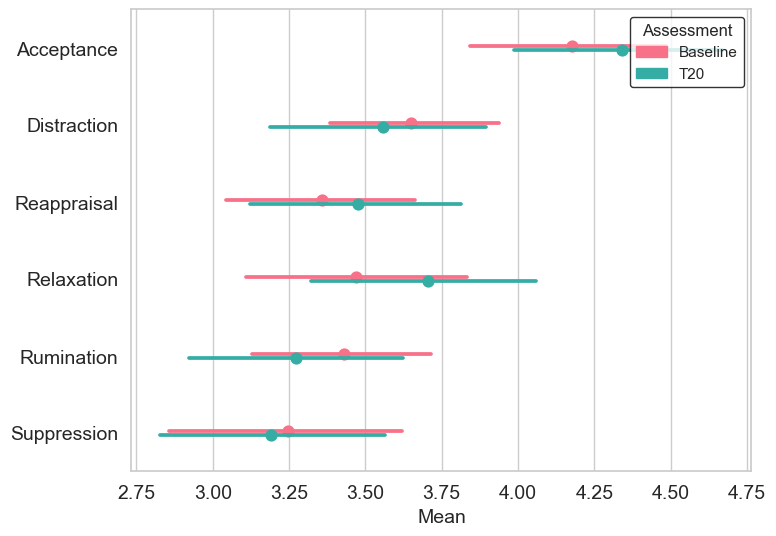

In [16]:

# Assuming your data is in a DataFrame called "mean_er"
melted_data = mean_er.melt(id_vars='assess', var_name='ER_Strategy', value_name='Mean_Value')
# Filter out non-numeric values in the 'Mean_Value' column
melted_data = melted_data[melted_data['Mean_Value'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
melted_data['Mean_Value'] = pd.to_numeric(melted_data['Mean_Value'])

# Preprocess the ER strategies column to remove "er_" prefix and capitalize the names
melted_data['ER_Strategy'] = melted_data['ER_Strategy'].str.replace('er_', '').str.capitalize()

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

# Define custom color palette
colors = sns.color_palette("husl", 2)

# Plotting using seaborn's pointplot with join=False to remove lines
sns.pointplot(x='Mean_Value', y='ER_Strategy', hue='assess', data=melted_data, dodge=True, join=False, palette=colors)

plt.xlabel('Mean')
plt.ylabel('')

# Create custom legend with colored patches for each group
legend_colors = {'Baseline': colors[0], 'T20': colors[1]}
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in legend_colors.items()]
plt.legend(handles=legend_patches, title='Assessment', loc='upper right', facecolor='white', edgecolor='black')

plt.savefig("er_strategy_plot.png", format="png")
plt.show()


### 4. Calculate average PANAS scores

In [17]:
panas_columns = [col for col in df_piv.columns if col.startswith('panas_')]

In [18]:
# Group by 'customer' and 'study', then calculate the mean of the panas_ columns
mean_panas = df_piv.groupby(['customer', 'assess'])[panas_columns].mean().reset_index()

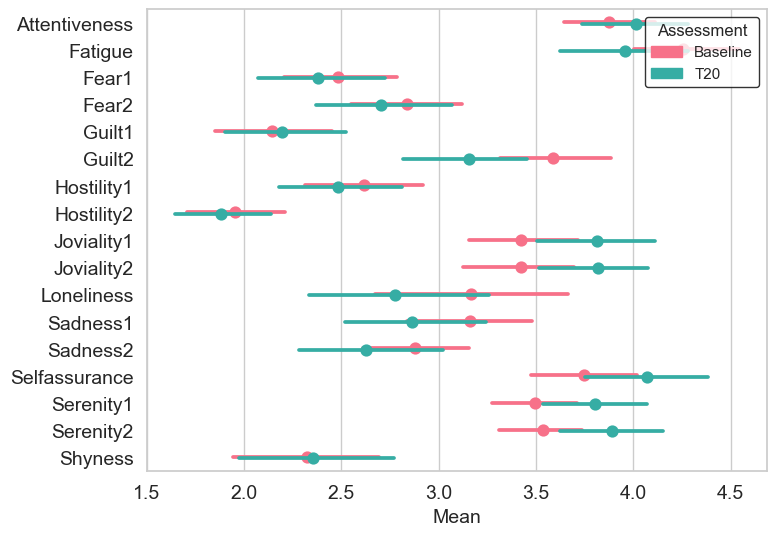

In [19]:

# Assuming your data is in a DataFrame called "mean_er"
melted_data = mean_panas.melt(id_vars='assess', var_name='PANAS', value_name='Mean_Value')
# Filter out non-numeric values in the 'Mean_Value' column
melted_data = melted_data[melted_data['Mean_Value'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
melted_data['Mean_Value'] = pd.to_numeric(melted_data['Mean_Value'])

melted_data['PANAS'] = melted_data['PANAS'].str.replace('panas_', '').str.capitalize()
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

# Define custom color palette
colors = sns.color_palette("husl", 2)

# Plotting using seaborn's pointplot with join=False to remove lines
sns.pointplot(x='Mean_Value', y='PANAS', hue='assess', data=melted_data, dodge=True, join=False, palette=colors)

plt.xlabel('Mean')
plt.ylabel('')

# Create custom legend with colored patches for each group
legend_colors = {'Baseline': colors[0], 'T20': colors[1]}
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in legend_colors.items()]
plt.legend(handles=legend_patches, title='Assessment', loc='upper right', facecolor='white', edgecolor='black')


### Combine EMA and BSI-GSI

In [20]:
df_outcome = df_active[['customer', 'rci', 'clinically_significant', 'reliable_change',
       'clinically_reliable_change']]
df_outcome = df_outcome.drop_duplicates(subset="customer")

In [21]:
df_outcome = df_outcome.merge(mean_panas, on="customer", how="inner")

### Check out TAI items

In [22]:
df_ema2 = df_ema2.loc[df_ema2.quest_title.isin(['ta_behavioral', 'ta_behavioral_2', 'ta_kognitiv', 'ta_kognitiv_2'])]

In [23]:
# Pivot the table as specified
df_ema2_piv = df_ema2.pivot_table(
    index=["customer", "unique_day_id"],
    columns="quest_title",
    values="choice_text",
    aggfunc='first'  # Using 'first' since each entry should theoretically be unique per group
)

# The columns are now a single level Index with just the quest_title values since 'values' is not a list anymore
df_ema2_piv.columns = [col for col in df_ema2_piv.columns.values]

# Reset the index to turn the MultiIndex into columns
df_ema2_piv = df_ema2_piv.reset_index()


In [24]:
ta_columns = [col for col in df_ema2_piv.columns if col.startswith('ta_')]


In [25]:
df_ema2_piv.customer.nunique()

42

In [26]:
df_ema2_piv

,customer,unique_day_id,ta_behavioral,ta_behavioral_2,ta_kognitiv,ta_kognitiv_2
0,0xWn,20240219_8,4,5,6,4
1,0xWn,20240220_8,4,4,6,5
2,0xWn,20240222_8,6,7,7,6
3,0xWn,20240223_8,6,5,6,6
4,0xWn,20240224_8,5,4,5,5
...,...,...,...,...,...,...
378,xlB8,20240618_8,6,4,6,6
379,xlB8,20240619_8,5,5,4,5
380,xlB8,20240621_8,4,4,5,4
381,xlB8,20240622_8,5,5,5,5


In [27]:
df_ema2_piv.groupby("customer")["ta_behavioral"].count()

customer
0xWn    12
1BAf    11
2gei     6
4MLe    14
5BAw    15
5MyR     6
6Bri    10
94FE     9
B54i     5
BdSf     9
CySo    14
D2mZ     6
GjiG    14
JIhV    15
JULY    11
K0go     2
M72F    11
QkCG    13
Snml    11
WYDb     3
YBuR    11
cFVk     9
dZYU     5
f1J2     3
fjGD    14
g6p5     3
gfo4     1
h29A    10
kVhY    12
lLs0     9
lWx4    12
nc7M    13
nhdk    15
nrqZ    15
o7oH    11
p4A1     2
pULz     1
pnfK    10
r7ty     5
uGoA     1
uP59    11
xlB8    13
Name: ta_behavioral, dtype: int64